In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time

res = requests.get("https://thehill.com/")
text = res.text

soup = BeautifulSoup(text, 'html.parser')

titles = []
for title in soup.find_all('a'):
    #If title already in list don't add
    if title.get('title') != None and title.get('title') not in titles and len(title.text.split()) > 2:
        titles.append(title.get('title'))


In [2]:
#Load cnn html using selenium because page is dynamic and need to get the source html
PATH = "C:\Program Files (x86)\chromedriver.exe"

opts = Options()
opts.set_headless() #keeps window closed
browser = webdriver.Chrome(PATH, options=opts) 
browser.get("https://www.cnn.com/") #run the site

cnnHtml = browser.page_source  #get the html

time.sleep(5)
browser.quit()

In [3]:
#Get fox html 
res = requests.get('https://www.foxnews.com/')

foxHtml = res.text

In [18]:
foxSoup = BeautifulSoup(foxHtml, 'html.parser')

articles = foxSoup.find_all('h2', class_ = 'title title-color-default')

foxTitles = []
for title in articles:
    if len(title.text.split()) > 2:
        foxTitles.append(title.text)

In [5]:
#parsing the cnn titles
import re

cnnSoup = BeautifulSoup(cnnHtml, 'html.parser')

#Get headline elements
cnnTags = cnnSoup.find_all('span', class_="cd__headline-text vid-left-enabled")

#extract text content
cnnTitles = []
for title in cnnTags:
    if len(title.split(" ")) > 2:
        cnnTitles.append(title.text)

In [19]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
from datetime import date

theHillHeadlines = pd.DataFrame({'id': np.random.randint(5000, 10000000, size=len(titles)), 'headline': titles}).set_index('id')#load to dataframe
theHillHeadlines['source'] = 'The Hill'

cnnHeadlines = pd.DataFrame({'id': np.random.randint(5000, 10000000, size=len(cnnTitles)), 'headline': cnnTitles}).set_index('id')
cnnHeadlines['source'] = 'CNN'

foxHeadlines = pd.DataFrame({'id': np.random.randint(5000, 10000000, size=len(foxTitles)), 'headline': foxTitles}).set_index('id')
foxHeadlines['source'] = 'Fox'

headlines = pd.concat([theHillHeadlines, foxHeadlines, cnnHeadlines], axis=0)
headlines['date'] = date.today().strftime("%m/%d/%Y")

headlines.head()


words = headlines['headline'].str.split(' ', expand=True).stack().reset_index(level=1).rename(columns={'level_1': 'position', 0: 'word'})

#remove punctuation
words['word'] = words['word'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


#filter stopwords out
words['word'] = words['word'].where(lambda x: ~x.isin(stopwords.words('english')))

words = words[words['word'].notna()]


#lemmatize words to remove plurals
def lem(x):
    lemmatizer = WordNetLemmatizer()
    lemmatized = lemmatizer.lemmatize(x)
    return lemmatized

words['word'] = words['word'].apply(lem)

headlines.head()

,headline,source,date
id,,,
2319811,"Trump, allies raise pressure on Senate GOP ahe...",The Hill,01/25/2021
2283315,"House formally sends impeachment to Senate, pu...",The Hill,01/25/2021
4107730,McConnell: Power-sharing deal can proceed afte...,The Hill,01/25/2021
8494529,State Watch,The Hill,01/25/2021
7332837,Portman planned exit sets off Ohio free-for-all,The Hill,01/25/2021


In [7]:
#load dataframe of word -> sentiment value
sentiment = pd.read_csv('vader_lexicon.txt', sep='\t', index_col=0, names=['polarity', 'normalized_polarity', 'matrix'])
sentiment = sentiment.drop(columns = sentiment.columns.difference(['polarity']))

#Merge word sentiments with each word and replace nan with 0s to be neutral
polarities = words.merge(sentiment, left_on='word', right_index=True, how='left').fillna(0.0)

#Get sum of polarites for each title
sums = polarities.groupby(level=0)['polarity'].sum()

#Add polarity value back to each title
headlines['sentiment'] = sums
mean = headlines['sentiment'].mean()

print("Average sentiment of hill articles: " + str(mean))

headlines.sample(n=25)


Average sentiment of hill articles: -0.1865546218487394


,headline,source,sentiment
id,,,
1063028,Biden executive orders look like 'America Last...,Fox,1.5
1962390,Video shows moment NYC firefighter knocked unc...,Fox,-0.6
3748300,This training bundle covers a huge variety of ...,The Hill,1.3
4639567,See what happened at GOP meeting in Arizona af...,CNN,-1.3
1477984,Trump sets up official post-presidency office ...,Fox,0.0
8246187,Testing rule for travelers,CNN,0.0
9064235,Get this highly effective mask designed for ex...,The Hill,2.1
9878223,Portman retirement sparks calls for LeBron Jam...,The Hill,0.9
7865386,Biden extends START arms treaty with Russia,Fox,0.5


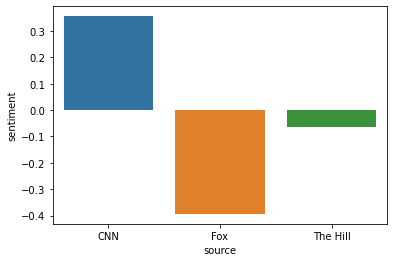

In [9]:
import seaborn as sns

meanSentiments = headlines.groupby('source').mean()

meanSentiments['sentiment']

sns.barplot(x=meanSentiments['sentiment'].index, y=meanSentiments['sentiment'])

In [11]:
headlines.nlargest(5, 'sentiment')

,headline,source,sentiment
id,,,
6185434,The best SAD lamps to help literally brighten ...,CNN,6.8
2635730,50 Valentine's Day gifts your loved ones will ...,CNN,4.8
4943215,"NFL to allow 22,000 fans at Super Bowl LV, inc...",CNN,4.4
3379385,Taibbi: Declining trust in media result of shi...,The Hill,4.1
9185002,White House holds call with senators to raise ...,CNN,3.8


In [12]:
headlines.nsmallest(5, 'sentiment')

,headline,source,sentiment
id,,,
1587026,Texas man charged for alleged role in Capitol ...,The Hill,-8.7
6838904,Serial killer invited to get COVID vaccine ign...,Fox,-5.6
5691003,"Trump impeachment trial is 'stupid,' 'bad for ...",Fox,-4.9
2052370,Lawmaker introduces bill doubling penalty for ...,The Hill,-4.6
5064374,Indianapolis police investigate 'mass murder' ...,Fox,-3.7


In [13]:
res = requests.get("https://mdedreu.com")

print(res.text)

<!doctype html>

<html lang="en">
<head>
  <meta charset="utf-8">

  <title>Michael DeDreu</title>

  <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" integrity="sha384-ggOyR0iXCbMQv3Xipma34MD+dH/1fQ784/j6cY/iJTQUOhcWr7x9JvoRxT2MZw1T" crossorigin="anonymous">
  <link rel="stylesheet" href="styles.css">
</head>

<body>
  <nav class="navbar navbar-expand-lg navbar-dark bg-dark">
    <a class="navbar-brand" href="#">Michael DeDreu</a>
    <button class="navbar-toggler" type="button" data-toggle="collapse" data-target="#navbarSupportedContent" aria-controls="navbarSupportedContent" aria-expanded="false" aria-label="Toggle navigation">
      <span class="navbar-toggler-icon"></span>
    </button>
  
    <div class="collapse navbar-collapse" id="navbarSupportedContent">
      <ul class="navbar-nav mr-auto">
        <li class="nav-item active">
          <a class="nav-link active" href="index.html">Home</a>
        </li>
        <li class=

In [16]:
headlines.loc[2052370]['headline']

'Lawmaker introduces bill doubling penalty for insurrection following Capitol riots'

In [28]:
headlines = pd.read_csv('headlines.csv').set_index('id')

In [30]:
headlines.tail()

,headline,source,date
id,,,
9073730,We tested nine top-rated hair dryers to find t...,CNN,01/26/2021
919706,Truff's pasta sauce is one of the best sauces ...,CNN,01/26/2021
3753168,Which Microsoft Surfaces are worth the money? ...,CNN,01/26/2021
5693934,The Amex Gold Card is effectively paying you t...,CNN,01/26/2021
1181777,The best coupons at Kohl's,CNN,01/26/2021


In [41]:
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import json

with open('keys.json', 'r') as keys:
    key = json.load(keys)['awsKey']

engine = create_engine(key)

headlines.to_sql('headlines', con=engine, if_exists='append')

In [38]:
headlines['headline'].str.len().max()

234